<a href="https://colab.research.google.com/github/codeSamuraii/ml-experiments/blob/main/CompressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JPEG Compression detection with Keras
The objective of this notebook is to train a machine learning model to recognise images that have been compressed using a lossy algorithm (such as JPEG) from original high-quality ones.

## Fetching and preparing the dataset files
We'll use a landscape images dataset from Kaggle.

_You'll need a Kaggle account to download the dataset._

In [ ]:
import os
import getpass

kaggle_ids = getpass.getpass('Content of your ~/.kaggle/kaggle.json: ')
os.environ['KAGGLE_JSON'] = kaggle_ids

!mkdir ~/.kaggle; echo $KAGGLE_JSON > ~/.kaggle/kaggle.json; chmod 600 ~/.kaggle/kaggle.json

Content of your ~/.kaggle/kaggle.json: ··········


Download the dataset:

In [ ]:
!mkdir /content/dataset; kaggle datasets download -d arnaud58/landscape-pictures -p /content/dataset --unzip

 99% 617M/620M [00:22<00:00, 38.7MB/s]
100% 620M/620M [00:22<00:00, 28.4MB/s]


We'll JPEG-compress the images using Pillow, and put them in separate folders under `training`, one for `compressed` images, one for `quality` images:

In [ ]:
!mkdir /content/training; mkdir /content/training/compressed; mkdir /content/training/quality

import os
import pathlib
import tensorflow as tf
from PIL import Image
from itertools import chain


quality_factor = 5

def process_images_for_training(src_dataset, dest_directory, ext_glob=None):
    # Images have different extensions
    folder = pathlib.Path(src_dataset).resolve()
    extensions = ext_glob or {'*.jpg', '*.jpeg'}
    images = list(chain.from_iterable(folder.glob(ext) for ext in extensions))
    nb_img, nb_errors = len(images), 0
    print(f'Found {nb_img} images.')

    for i, image_file in enumerate(images):
        try:
            im = Image.open(image_file, formats=['JPEG'])
            im.save(f'{dest_directory}/quality/{i}.jpg', optimize=True, quality='keep')
        except (OSError, ValueError):
            nb_errors += 1
            continue

        im.save(f'{dest_directory}/compressed/{i}.jpg', optimize=False, quality=quality_factor)

        if i % 1000 == 0:
            progress = int(i / nb_img * 100)
            print(f'{progress}% ({i}/{nb_img} E={nb_errors})')

    print('Done.')

process_images_for_training('/content/dataset', '/content/training')

Found 4319 images.
0% (0/4319 E=0)
23% (1000/4319 E=0)
46% (2000/4319 E=0)
69% (3000/4319 E=0)
92% (4000/4319 E=0)
Done.


## Splitting the dataset
Now that we have created our compressed images, let's use Keras to split the dataset between training and validation. Keras will understand that each subdirectory of `training` is a class we're trying to predict.

In [ ]:
import tensorflow as tf


batch_size = 12
img_height = 500
img_width = 500


def dataset_from_directory(training_dir):
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        validation_split=0.2,
        subset='training',
        seed=42,
        image_size=(img_height, img_width),
        crop_to_aspect_ratio=True,
        # label_mode='binary',
        batch_size=batch_size
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        validation_split=0.2,
        subset='validation',
        seed=42,
        image_size=(img_height, img_width),
        crop_to_aspect_ratio=True,
        # label_mode='binary',
        batch_size=batch_size
    )

    return train_dataset, validation_dataset

train_dataset, validation_dataset = dataset_from_directory('/content/training')
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

Found 8638 files belonging to 2 classes.
Using 6911 files for training.
Found 8638 files belonging to 2 classes.
Using 1727 files for validation.
2 classes: ['compressed', 'quality']


Note that the dataset has been configured to perform a _categorical_ classification.

It is suited for classifications with two or more classes. The output will be the computed probability for an image to belong to each class: `[0.97, 0.03]` for example.

> Considering we are only trying to predict if an image is compressed or not, we could have used a _binary_ classification, which would only output "yes" (`1`) or "no" (`0`). For that we would need to uncomment `label_mode='binary'` and modify the model's output layer.

We check that pictures have been assigned to the correct label:

Pixel values in [0.0:255.0]


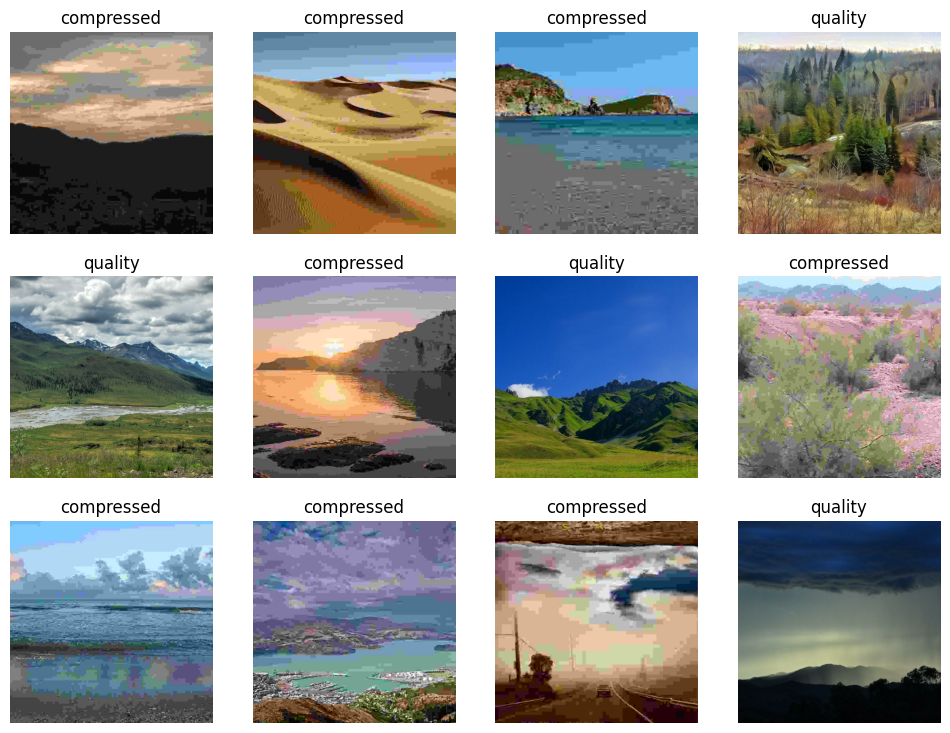

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def show_dataset(dataset):
    plt.figure(figsize=(12, 9))
    for images, labels in dataset.take(1):
      for i in range(batch_size):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

    image_batch, _ = next(iter(dataset))
    first_image = image_batch[0]
    print(f'Pixel values in [{np.min(first_image)}:{np.max(first_image)}]')

show_dataset(train_dataset)

We can see that compressed images have artifacts, especially in gradient areas like the sky. Our model should be able to pick up these details.

## Create the model and train
We create a basic CNN network made of convolutions and pooling layers increasing in filter size.

To prevent overfitting, the images go through preprocessing layers where data augmentation operations are performed such as flip, zoom and rotation. Two dropouts layers further help stabilising predictions.

Data is rescaled to the `[0: 100]` range during that process as it is common when using RGB data.

We also put in place checkpoint and early stopping callbacks that will stop the training prematurely if performance drops and restore the best weights.

> For a *binary* classification, we would need an output layer of dimension `1` with sigmoid activation and a *binary crossentropy* loss function.

In [ ]:
!rm /tmp/*.h5 2> /dev/null
import tempfile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


preprocess = keras.Sequential([
    # Augmentation
    layers.RandomFlip(input_shape=(img_height, img_width, 3)),
    layers.RandomZoom((0.0, 0.2)),
    layers.RandomRotation(0.1, fill_mode='constant'),

    # Rescaling
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
])

model = Sequential([
    preprocess,

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.2),
    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),

    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adamax',
              loss='sparse_categorical_crossentropy',  # loss='binary_crossentropy',
              metrics=['accuracy'])

_, checkpoint_file = tempfile.mkstemp(prefix='checkpoint_', suffix='.h5', dir='/tmp')
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_file, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(start_from_epoch=10, patience=6, restore_best_weights=True)

history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[checkpoint, early_stop])

loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)



Epoch 1/50
576/576 [==============================] - 59s 98ms/step - loss: 0.9718 - accuracy: 0.5005 - val_loss: 0.6911 - val_accuracy: 0.5211
Epoch 2/50
576/576 [==============================] - 57s 99ms/step - loss: 0.6928 - accuracy: 0.5164 - val_loss: 0.6859 - val_accuracy: 0.5350
Epoch 3/50
576/576 [==============================] - 59s 102ms/step - loss: 0.6809 - accuracy: 0.5503 - val_loss: 0.6540 - val_accuracy: 0.6642
Epoch 4/50
576/576 [==============================] - 57s 99ms/step - loss: 0.6064 - accuracy: 0.6630 - val_loss: 0.5280 - val_accuracy: 0.7620
Epoch 5/50
576/576 [==============================] - 60s 103ms/step - loss: 0.4918 - accuracy: 0.7588 - val_loss: 0.3063 - val_accuracy: 0.9004
Epoch 6/50
576/576 [==============================] - 60s 105ms/step - loss: 0.2792 - accuracy: 0.8834 - val_loss: 0.1342 - val_accuracy: 0.9612
Epoch 7/50
576/576 [==============================] - 48s 84ms/step - loss: 0.1601 - accuracy: 0.9397 - val_loss: 0.1477 - val_accura

We can see the model wasn't improving after epoch 26, weights have therefore been restored to that training step.

## Review performance

Let's plot the training statistics :

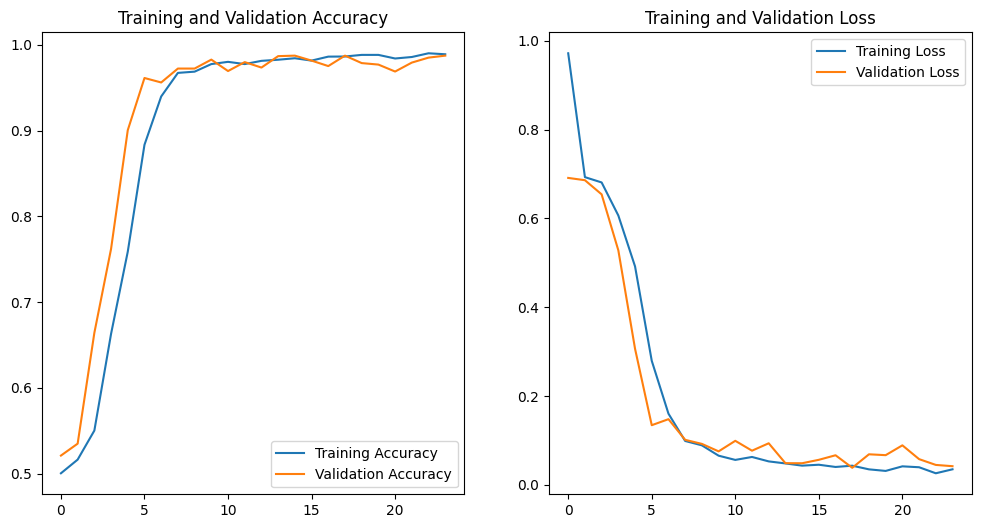

In [ ]:
def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    nb_epochs = len(history.history['val_loss'])
    epochs_range = range(nb_epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_performance(history)

We can see that there was no overfitting and validation loss nicely follows training.

## Make some predictions
Let's try some random predictions :

In [ ]:
import random
import numpy as np
from random import choice


def gen_random_class_and_images(n):
    compressed_files = list(pathlib.Path(f'/content/training/compressed').glob('*.jpg'))
    quality_files = list(pathlib.Path(f'/content/training/quality').glob('*.jpg'))
    classes = [
        ('compressed', lambda: random.choice(compressed_files)),
        ('quality', lambda: random.choice(quality_files))
    ]

    for _ in range(n):
        rand_class, rand_img = random.choice(classes)
        yield rand_class, rand_img()

# 100 random predictions
for rand_class, rand_img in gen_random_class_and_images(100):
    img = tf.keras.utils.load_img(rand_img, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    pred_class, pred_confidence = class_names[np.argmax(score)], 100 * np.max(score)
    if pred_class != rand_class:
        print(f'FAIL - input: {rand_class} > pred: {pred_class} ({pred_confidence:.2f}) - {rand_img}')


FAIL - input: compressed > pred: quality (58.22) - /content/training/compressed/916.jpg
FAIL - input: quality > pred: compressed (63.58) - /content/training/quality/692.jpg


We can see that our model performs decently. When it fails to predict the right answer, the confidence score is low (~60%). In a real application, we could filter results with a minimum score.

## Save the model
Let's save our model, we can use it for predictions straight away or for reinforcement learning.

In [ ]:
import os
import tempfile
from keras.models import load_model
model = load_model('/content/trained_q5_987_4pbpq46p.keras')
accuracy = 0.9870
quality_factor = 5

In [ ]:
print("Saving model...")
file_name = f'landscape_q{quality_factor}_{int(accuracy * 1000)}'
_, model_file = tempfile.mkstemp(prefix=file_name + '_', suffix='.keras', dir='/content')
model.save(model_file)
print("Saved to: ", model_file)

if input('Save compressed to Drive ? [y/N] ') in {'y', 'Y'}:
    _, hdf_file = tempfile.mkstemp(prefix=file_name + '_', suffix='.h5', dir='/tmp')
    os.environ['TMP_MODEL_PATH'] = hdf_file
    os.environ['TF_MODEL_NAME'] = file_name + '.tflite'
    !tflite_convert --keras_model_file=$TMP_MODEL_PATH --output_file=/content/drive/MyDrive/trained_models/$TF_MODEL_NAME

Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved to:  /content/landscape_q5_987_llzndsy1.h5
Save compressed to Drive ? [y/N] y
2023-09-19 10:59:32.722504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-19 10:59:35.343541: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0919 10:59:47.501994 136179569160832 signature_serialization.py:148] Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to sequential_7_dense_11_biasadd_readvariableop_resource in the SavedModel.
I0919 10:59:48.005574 136179569160832 save.py:274] Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _update_step_xla while saving (showing 4 of 4). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tmp

# Improving generalization with transfer learning
Our current model is able to differentiate compressed _landscape_ images from original ones. However, it wouldn't perform well with a different kind of picture.

Using transfer learning and a different set of pictures, we'll improve our model ability to generalize.

_See [part two](https://colab.research.google.com/drive/1yGgjgDupeYi5gE641EvZ3OPnuxxuyDue?usp=sharing)._